- 월별 집계 및 시계열 플로우 통한 평행추세 검증
- 군집 robust 표준오차 사용
- 월 고정효과를 포함한 DiD 모형 추정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. 데이터 로드 및 전처리

In [2]:
df = pd.read_excel('../data/online+retail/Online Retail.xlsx')
df = df[df['CustomerID'].notnull()]
df['purchase_amount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2. 월별 집계용 변수 생성 (YYYY-MM 형식)

In [3]:
df['month'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# 3. 캠페인 도입 전후 구분 (캠페인 시작인: 2011-12-01)

In [4]:
campaign_start = pd.to_datetime('2011-12-01')
df['time'] = (df['InvoiceDate'] >= campaign_start).astype(int)

# 4. 처리군/통제군 설정 (여기서는 랜덤 할당)

In [7]:
unique_cutomers = df['CustomerID'].unique()
np.random.seed(42)  # 재현성을 위해 시드 고정
treatment_assignment = {customer: np.random.binomial(1, 0.5) for customer in unique_cutomers}
df['treated_flag'] = df['CustomerID'].map(treatment_assignment)

# 5. 고객별, 월별로 구매액 집계

In [9]:
agg_df = df.groupby(['CustomerID', 'treated_flag', 'month'])['purchase_amount'].sum().reset_index()

In [11]:
# 월 정보를 datetime으로 변환 (해당 월의 첫째 날)
agg_df['month_dt'] = pd.to_datetime(agg_df['month'] + '-01')
# 캠페인 기준에 따라 재정의 (월 단위)
agg_df['time'] = (agg_df['month_dt'] >= campaign_start).astype(int)

# 6. 평행추세 검증: 캠페인 이전 기간의 월별 평균 구매액 추세 플록

In [13]:
pre_campaign = agg_df[agg_df['time'] == 0]
pre_trends = pre_campaign.groupby(['month', 'treated_flag'])['purchase_amount'].mean().reset_index()
pre_trends['month_dt'] = pd.to_datetime(pre_trends['month']+'-01')

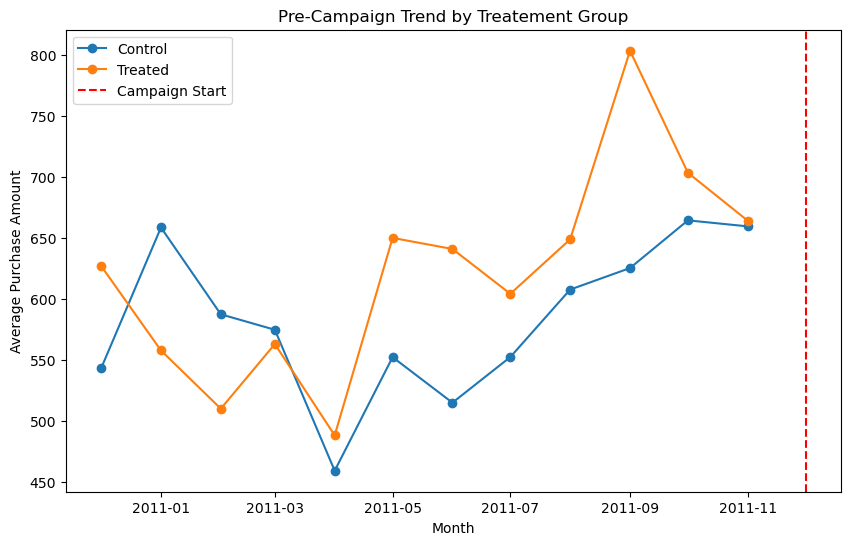

In [14]:
plt.figure(figsize=(10,6))
for flag in sorted(pre_trends['treated_flag'].unique()):
    subset = pre_trends[pre_trends['treated_flag'] == flag]
    label = 'Treated' if flag == 1 else 'Control'
    plt.plot(subset['month_dt'], subset['purchase_amount'], marker='o', label=label)
plt.axvline(campaign_start, color='red', linestyle='--', label='Campaign Start')
plt.xlabel('Month')
plt.ylabel('Average Purchase Amount')
plt.title('Pre-Campaign Trend by Treatement Group')
plt.legend()
plt.show()

# 7. DiD 분석: 기본 모형 (군집 roubst 표준오차, 고객별 클러스터링)

In [15]:
did_model = smf.ols(
    formula='purchase_amount ~ treated_flag + time + treated_flag:time', 
    data=agg_df
    ).fit(cov_type='cluster', cov_kwds={'groups': agg_df['CustomerID']})

print("DiD 분석 결과 (기본 모형):")
print(did_model.summary())

DiD 분석 결과 (기본 모형):
                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.126
Date:                Tue, 18 Feb 2025   Prob (F-statistic):            0.00624
Time:                        09:08:35   Log-Likelihood:            -1.2118e+05
No. Observations:               13675   AIC:                         2.424e+05
Df Residuals:                   13671   BIC:                         2.424e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          

# 8. DiD 분석: 월 고정효과 추가 (계절성 및 시간추세 통제)

In [16]:
did_model_fe = smf.ols(
    formula = 'purchase_amount ~ treated_flag + time + treated_flag:time + C(month)',
    data=agg_df
).fit(cov_type='cluster', cov_kwds={'groups': agg_df['CustomerID']})

print("\nDiD 분석 결과 (월 고정효과 포함):")
print(did_model_fe.summary())


DiD 분석 결과 (월 고정효과 포함):
                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.782
Date:                Tue, 18 Feb 2025   Prob (F-statistic):           2.14e-06
Time:                        09:10:48   Log-Likelihood:            -1.2117e+05
No. Observations:               13675   AIC:                         2.424e+05
Df Residuals:                   13660   BIC:                         2.425e+05
Df Model:                          14                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept 

c:\Users\PC\miniconda3\envs\portfolio\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '


**결과 해석**

- **기본 모형:**
    - **Intercept (590.86):** 캠페인 이전 통제군의 평균 구매액를 나타냅니다.
    - **treated_flag (43.20, p=0.569):** 캠페인 이전 처리군과 통제군의 구매액 차이는 크지 않으며 통계적으로 유의하지 않습니다.
    - **time (-97.68, p=0.011):** 캠페인 이후 통제군의 구매액이 약 98만큼 감소했음을 보여주며, 이는 계절성이나 외부 요인에 따른 전반적 하락일 가능성이 있습니다.
    - **treated_flag:time (-31.11, p=0.636):** 캠페인 이후 처리군과 통제군 간의 추가 차이는 유의하지 않으므로, 캠페인이 처리군의 구매액에 미친 추가 효과는 통계적으로 나타나지 않습니다.
- **월 고정효과 모형:**
    - 월별 계절성과 시간추세를 통제한 결과, DiD 상호작용 항(treated_flag:time)의 계수(-32.52, p=0.621)는 여전히 유의하지 않습니다.
    - 일부 월별 더미 변수는 유의한 효과를 보이지만, 전체적으로 캠페인 효과 자체는 통계적으로 유의하지 않음을 시사합니다.
- **비교:**
    - 이전 프로젝트에서는 캠페인 이후 통제군의 구매액 감소(time 계수 약 -1270)가 더 크게 나타났지만, DiD 효과(상호작용 항)는 역시 유의하지 않았습니다.
    - 두 프로젝트 모두 전체 설명력이 낮은 편(R²≈0.004~0.002)이며, 이는 모델에 포함된 변수 외에도 구매액에 영향을 주는 요인이 많음을 암시합니다.